In [1]:
import os
import sys
import datetime as dt
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [109]:
path = '..\\data\\raw'
merchant_df = pd.read_csv(f'{path}\\merchants.csv')
trans_df = pd.read_csv(f'{path}\\transactions.csv',parse_dates=['timestamp'])
users_df = pd.read_csv(f'{path}\\users.csv')

In [110]:
merchant_df['is_fraud'].value_counts()

is_fraud
0.0    2323
1.0     176
Name: count, dtype: int64

In [80]:
merchant_df.head()

,merchant_id,category,city,avg_trans_amount,is_fraud
0,merch_0,Entertainment,Surat,1200,0.0
1,merch_1,Sports,Patna,1000,0.0
2,merch_2,Fashion,Noida,800,0.0
3,merch_3,Travel,Mumbai,5000,0.0
4,merch_4,Fashion,Delhi,800,0.0


In [19]:
merchant_df.shape

(2500, 5)

In [20]:
merchant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   merchant_id       2500 non-null   object 
 1   category          2500 non-null   object 
 2   city              2500 non-null   object 
 3   avg_trans_amount  2500 non-null   int64  
 4   is_fraud          2499 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 97.8+ KB


In [6]:
trans_df.head()

,trans_id,user_id,merchant_id,device_id,amount,timestamp
0,t_0,user_1411,merch_204,device_1523,3473.87,2025-12-10T12:33:31.714957
1,t_1,user_2351,merch_2006,device_1028,1787.07,2025-12-19T17:52:35.714957
2,t_2,user_1242,merch_1143,device_1584,2374.46,2025-12-15T10:12:46.714957
3,t_3,user_314,merch_2497,device_732,1550.93,2025-12-09T07:05:10.725461
4,t_4,user_3143,merch_620,device_1731,7000.00,2025-10-29T14:52:53.725461


In [7]:
trans_df.shape

(22000, 6)

In [8]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   trans_id     22000 non-null  object 
 1   user_id      22000 non-null  object 
 2   merchant_id  22000 non-null  object 
 3   device_id    22000 non-null  object 
 4   amount       22000 non-null  float64
 5   timestamp    22000 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.0+ MB


In [9]:
users_df.head()

,user_id,age_bucket,age,state,user_risk_score
0,user_0,35-44,41,UP,0.020959
1,user_1,45-60,47,DL,0.203283
2,user_2,18-24,21,RJ,0.051846
3,user_3,35-44,42,TN,0.103352
4,user_4,35-44,40,MH,0.018463


In [10]:
users_df.shape

(4000, 5)

In [11]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          4000 non-null   object 
 1   age_bucket       4000 non-null   object 
 2   age              4000 non-null   int64  
 3   state            4000 non-null   object 
 4   user_risk_score  4000 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 156.4+ KB


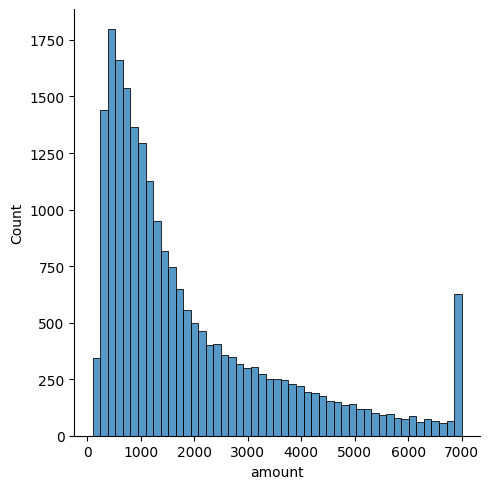

In [81]:
sns.displot(trans_df['amount'])

#### What I found

With this graph I found that small amount transactions are more and there are very few transactions with very high amount.

     merchant_id  count
2093   merch_633     21
426   merch_1381     19
2370   merch_883     18
197   merch_1175     18
2000    merch_55     18
2350   merch_865     17
802    merch_172     17
737   merch_1661     17
1746   merch_320     17
1038  merch_1933     17


<BarContainer object of 2499 artists>

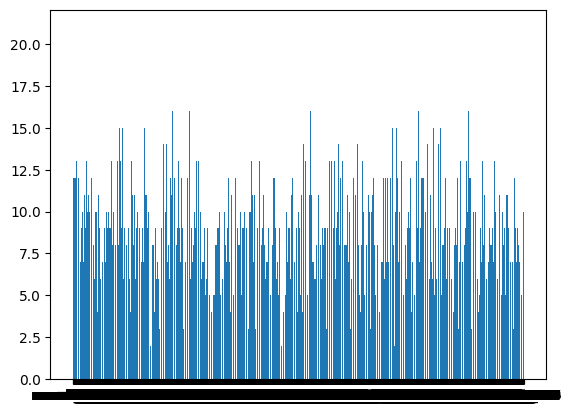

In [111]:
#Merchant activity
merch_activity_series = trans_df.groupby(['merchant_id']).size().reset_index(name='count')
print(merch_activity_series.sort_values(['count'],ascending=False).head(10))
plt.bar(merch_activity_series['merchant_id'],merch_activity_series['count'])

##### What I found
The merchant activity distribution is mostly uniform with ~8–10 transactions per merchant, but a small set of merchants show extremely high activity. These high-degree merchants will receive stronger neighborhood signals during message passing, leading to more confident embeddings. However, high activity alone does not indicate fraud; fraud must be inferred from behavioral patterns such as transaction size, timing, and shared users

###### Next Step

Now I'll create a dataframe with transactions and merchants which will have below columns and will try a model to predict the fraud merchant with the tabular data. If the model can predict the fraud merchant precisely then we do not need GNN.

1. merchant_id
2. total_transaction_count
3. avg_transaction_amount
4. std_transaction_amount
5. night_transaction_ratio
6. unique_user_count
7. category_encoded
8. city_encoded
9. is_fraud_merchant

In [112]:
merchant_df_copy = merchant_df.copy()
merchant_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   merchant_id       2500 non-null   object 
 1   category          2500 non-null   object 
 2   city              2500 non-null   object 
 3   avg_trans_amount  2500 non-null   int64  
 4   is_fraud          2499 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 97.8+ KB


In [113]:
merchant_df_copy.dropna(subset=['is_fraud'],inplace=True)

In [114]:
merchant_df_copy['is_fraud'] = merchant_df_copy['is_fraud'].astype(int)

In [115]:
merchant_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2499 entries, 0 to 2499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   merchant_id       2499 non-null   object
 1   category          2499 non-null   object
 2   city              2499 non-null   object
 3   avg_trans_amount  2499 non-null   int64 
 4   is_fraud          2499 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 117.1+ KB


In [116]:
# total transaction count

total_trans_df = trans_df.groupby('merchant_id').size().reset_index(name='total_transaction_count')
merchant_features_df = merchant_df_copy.merge(total_trans_df,how='left',on='merchant_id')
merchant_features_df['total_transaction_count'] = (merchant_features_df['total_transaction_count'].fillna(0))
merchant_features_df

,merchant_id,category,city,avg_trans_amount,is_fraud,total_transaction_count
0,merch_0,Entertainment,Surat,1200,0,5
1,merch_1,Sports,Patna,1000,0,6
2,merch_2,Fashion,Noida,800,0,12
3,merch_3,Travel,Mumbai,5000,0,10
4,merch_4,Fashion,Delhi,800,0,9
...,...,...,...,...,...,...
2494,merch_2495,Gaming,Bangalore,1500,0,10
2495,merch_2496,Fashion,Surat,800,0,5
2496,merch_2497,Services,Delhi,3500,0,7
2497,merch_2498,Electronics,Surat,2200,0,12


In [117]:
# standard deviation of transaction amount

temp_df = trans_df.groupby('merchant_id')['amount'].agg(np.std).reset_index(name='std_trans_amount')
merchant_features_df = merchant_features_df.merge(temp_df,how='left',on='merchant_id')
merchant_features_df['std_trans_amount'] = (merchant_features_df['std_trans_amount'].fillna(0))
merchant_features_df

C:\Users\DELL\AppData\Local\Temp\ipykernel_21396\3314937462.py:3: FutureWarning: The provided callable <function std at 0x00000258600BE200> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  temp_df = trans_df.groupby('merchant_id')['amount'].agg(np.std).reset_index(name='std_trans_amount')


,merchant_id,category,city,avg_trans_amount,is_fraud,total_transaction_count,std_trans_amount
0,merch_0,Entertainment,Surat,1200,0,5,509.487495
1,merch_1,Sports,Patna,1000,0,6,573.981317
2,merch_2,Fashion,Noida,800,0,12,312.919137
3,merch_3,Travel,Mumbai,5000,0,10,1442.798243
4,merch_4,Fashion,Delhi,800,0,9,270.144244
...,...,...,...,...,...,...,...
2494,merch_2495,Gaming,Bangalore,1500,0,10,595.841294
2495,merch_2496,Fashion,Surat,800,0,5,703.213954
2496,merch_2497,Services,Delhi,3500,0,7,1578.834487
2497,merch_2498,Electronics,Surat,2200,0,12,618.727120


In [118]:
#converting Timestamp datatype from object to datetime

temp_df = trans_df.copy()
temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'],errors='raise',format='mixed')

temp_df['timestamp'].isnull().sum()

np.int64(0)

In [119]:
# night transaction

hour = temp_df['timestamp'].dt.hour

temp_df['night_trans'] = ((hour >= 22) | (hour < 4)).astype(int)

In [120]:
temp_df

,trans_id,user_id,merchant_id,device_id,amount,timestamp,night_trans
0,t_0,user_1425,merch_2152,device_1516,1674.72,2025-12-02 21:21:16.957212,0
1,t_1,user_1706,merch_696,device_1393,404.23,2025-10-20 21:32:07.973204,0
2,t_2,user_3562,merch_1707,device_633,1724.76,2025-10-21 14:09:39.973204,0
3,t_3,user_2596,merch_164,device_1563,1412.82,2025-12-22 11:29:24.973204,0
4,t_4,user_221,merch_2234,device_839,978.49,2025-10-04 21:17:26.973204,0
...,...,...,...,...,...,...,...
21995,t_21995,user_482,merch_2489,device_829,737.35,2025-11-21 15:19:09.963679,0
21996,t_21996,user_3630,merch_713,device_1989,870.99,2025-12-19 20:29:43.964681,0
21997,t_21997,user_1774,merch_169,device_1206,440.86,2025-11-25 11:41:10.964681,0
21998,t_21998,user_3782,merch_1936,device_1543,1006.17,2025-12-11 02:52:03.965683,1


In [121]:
# night transaction count

temp_trans_df = temp_df.groupby('merchant_id')['night_trans'].sum().reset_index(name='night_transaction_count')
merchant_features_df = merchant_features_df.merge(temp_trans_df,how='left',on='merchant_id')
merchant_features_df

,merchant_id,category,city,avg_trans_amount,is_fraud,total_transaction_count,std_trans_amount,night_transaction_count
0,merch_0,Entertainment,Surat,1200,0,5,509.487495,0
1,merch_1,Sports,Patna,1000,0,6,573.981317,2
2,merch_2,Fashion,Noida,800,0,12,312.919137,1
3,merch_3,Travel,Mumbai,5000,0,10,1442.798243,4
4,merch_4,Fashion,Delhi,800,0,9,270.144244,4
...,...,...,...,...,...,...,...,...
2494,merch_2495,Gaming,Bangalore,1500,0,10,595.841294,3
2495,merch_2496,Fashion,Surat,800,0,5,703.213954,1
2496,merch_2497,Services,Delhi,3500,0,7,1578.834487,3
2497,merch_2498,Electronics,Surat,2200,0,12,618.727120,4


In [122]:
# night transaction ratio

merchant_features_df['night_transaction_count'] = (merchant_features_df['night_transaction_count'].fillna(0))
merchant_features_df['night_transaction_ratio'] = merchant_features_df['night_transaction_count']/merchant_features_df['total_transaction_count'].replace(0,1)
merchant_features_df

,merchant_id,category,city,avg_trans_amount,is_fraud,total_transaction_count,std_trans_amount,night_transaction_count,night_transaction_ratio
0,merch_0,Entertainment,Surat,1200,0,5,509.487495,0,0.000000
1,merch_1,Sports,Patna,1000,0,6,573.981317,2,0.333333
2,merch_2,Fashion,Noida,800,0,12,312.919137,1,0.083333
3,merch_3,Travel,Mumbai,5000,0,10,1442.798243,4,0.400000
4,merch_4,Fashion,Delhi,800,0,9,270.144244,4,0.444444
...,...,...,...,...,...,...,...,...,...
2494,merch_2495,Gaming,Bangalore,1500,0,10,595.841294,3,0.300000
2495,merch_2496,Fashion,Surat,800,0,5,703.213954,1,0.200000
2496,merch_2497,Services,Delhi,3500,0,7,1578.834487,3,0.428571
2497,merch_2498,Electronics,Surat,2200,0,12,618.727120,4,0.333333


In [123]:
# unique user count per merchant

unique_user_df = temp_df.groupby('merchant_id')['user_id'].nunique().reset_index(name='unique_user_count')
merchant_features_df = merchant_features_df.merge(unique_user_df,how='left',on='merchant_id')
merchant_features_df['unique_user_count'] = (merchant_features_df['unique_user_count'].fillna(0))
merchant_features_df

,merchant_id,category,city,avg_trans_amount,is_fraud,total_transaction_count,std_trans_amount,night_transaction_count,night_transaction_ratio,unique_user_count
0,merch_0,Entertainment,Surat,1200,0,5,509.487495,0,0.000000,5
1,merch_1,Sports,Patna,1000,0,6,573.981317,2,0.333333,6
2,merch_2,Fashion,Noida,800,0,12,312.919137,1,0.083333,12
3,merch_3,Travel,Mumbai,5000,0,10,1442.798243,4,0.400000,10
4,merch_4,Fashion,Delhi,800,0,9,270.144244,4,0.444444,9
...,...,...,...,...,...,...,...,...,...,...
2494,merch_2495,Gaming,Bangalore,1500,0,10,595.841294,3,0.300000,10
2495,merch_2496,Fashion,Surat,800,0,5,703.213954,1,0.200000,5
2496,merch_2497,Services,Delhi,3500,0,7,1578.834487,3,0.428571,5
2497,merch_2498,Electronics,Surat,2200,0,12,618.727120,4,0.333333,12


In [124]:
# droping night transaction count because it is not required in the model as we are using the night_transaction_ratio

merchant_features_df.drop('night_transaction_count',axis=1,inplace=True,errors='ignore')
merchant_features_df

,merchant_id,category,city,avg_trans_amount,is_fraud,total_transaction_count,std_trans_amount,night_transaction_ratio,unique_user_count
0,merch_0,Entertainment,Surat,1200,0,5,509.487495,0.000000,5
1,merch_1,Sports,Patna,1000,0,6,573.981317,0.333333,6
2,merch_2,Fashion,Noida,800,0,12,312.919137,0.083333,12
3,merch_3,Travel,Mumbai,5000,0,10,1442.798243,0.400000,10
4,merch_4,Fashion,Delhi,800,0,9,270.144244,0.444444,9
...,...,...,...,...,...,...,...,...,...
2494,merch_2495,Gaming,Bangalore,1500,0,10,595.841294,0.300000,10
2495,merch_2496,Fashion,Surat,800,0,5,703.213954,0.200000,5
2496,merch_2497,Services,Delhi,3500,0,7,1578.834487,0.428571,5
2497,merch_2498,Electronics,Surat,2200,0,12,618.727120,0.333333,12


In [125]:
# One Hot Encoding of Categorical Columns


categorical_columns = ['category', 'city']
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False, dtype=np.int32)
encoded_cat_cols = ohe.fit_transform(merchant_features_df[categorical_columns])
merchant_features_df = pd.concat(
    [
        merchant_features_df.drop(categorical_columns,axis = 1),
        pd.DataFrame(
            encoded_cat_cols,
            columns = ohe.get_feature_names_out(categorical_columns),
            index = merchant_features_df.index
        )
    ],
    axis = 1
)
merchant_features_df

,merchant_id,avg_trans_amount,is_fraud,total_transaction_count,std_trans_amount,night_transaction_ratio,unique_user_count,category_Entertainment,category_Fashion,category_Food,...,category_Sports,category_Travel,city_Chennai,city_Delhi,city_Jaipur,city_Mumbai,city_Noida,city_Patna,city_Surat,city_Vizag
0,merch_0,1200,0,5,509.487495,0.000000,5,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,merch_1,1000,0,6,573.981317,0.333333,6,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,merch_2,800,0,12,312.919137,0.083333,12,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,merch_3,5000,0,10,1442.798243,0.400000,10,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,merch_4,800,0,9,270.144244,0.444444,9,0,1,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,merch_2495,1500,0,10,595.841294,0.300000,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2495,merch_2496,800,0,5,703.213954,0.200000,5,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2496,merch_2497,3500,0,7,1578.834487,0.428571,5,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2497,merch_2498,2200,0,12,618.727120,0.333333,12,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [126]:
target_column = merchant_features_df.pop('is_fraud')
merchant_features_df = pd.concat([merchant_features_df,target_column],axis = 1)
merchant_features_df

,merchant_id,avg_trans_amount,total_transaction_count,std_trans_amount,night_transaction_ratio,unique_user_count,category_Entertainment,category_Fashion,category_Food,category_Gaming,...,category_Travel,city_Chennai,city_Delhi,city_Jaipur,city_Mumbai,city_Noida,city_Patna,city_Surat,city_Vizag,is_fraud
0,merch_0,1200,5,509.487495,0.000000,5,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,merch_1,1000,6,573.981317,0.333333,6,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,merch_2,800,12,312.919137,0.083333,12,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,merch_3,5000,10,1442.798243,0.400000,10,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,merch_4,800,9,270.144244,0.444444,9,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,merch_2495,1500,10,595.841294,0.300000,10,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2495,merch_2496,800,5,703.213954,0.200000,5,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2496,merch_2497,3500,7,1578.834487,0.428571,5,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2497,merch_2498,2200,12,618.727120,0.333333,12,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [127]:
merchant_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   merchant_id              2499 non-null   object 
 1   avg_trans_amount         2499 non-null   int64  
 2   total_transaction_count  2499 non-null   int64  
 3   std_trans_amount         2499 non-null   float64
 4   night_transaction_ratio  2499 non-null   float64
 5   unique_user_count        2499 non-null   int64  
 6   category_Entertainment   2499 non-null   int32  
 7   category_Fashion         2499 non-null   int32  
 8   category_Food            2499 non-null   int32  
 9   category_Gaming          2499 non-null   int32  
 10  category_Groceries       2499 non-null   int32  
 11  category_Services        2499 non-null   int32  
 12  category_Sports          2499 non-null   int32  
 13  category_Travel          2499 non-null   int32  
 14  city_Chennai            

##### Now modeling the Logistic regeression to see how LR performs on such dataset and able to find fraud merchants or not

In [72]:
temp_model_df = merchant_features_df.drop(['total_transaction_count'],axis=1)
temp_model_df

,merchant_id,avg_trans_amount,std_trans_amount,night_transaction_ratio,unique_user_count,category_Entertainment,category_Fashion,category_Food,category_Gaming,category_Groceries,...,category_Travel,city_Chennai,city_Delhi,city_Jaipur,city_Mumbai,city_Noida,city_Patna,city_Surat,city_Vizag,is_fraud
0,merch_0,1200,420.745203,0.000000,4,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,merch_1,1000,209.979549,0.250000,4,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,merch_2,800,201.347794,0.400000,5,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,merch_3,5000,1980.358607,0.000000,2,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,merch_4,800,244.284562,0.333333,3,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2433,merch_2495,1500,350.852243,0.500000,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2434,merch_2496,800,286.432554,0.000000,3,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2435,merch_2497,3500,1323.149659,0.250000,61,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2436,merch_2498,2200,890.501806,0.166667,6,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [73]:
X, y = temp_model_df.iloc[:,1:-1], temp_model_df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y)
temp_lr = LogisticRegression(max_iter=1000)

temp_lr.fit(X_train, y_train)
temp_predicted_value = temp_lr.predict(X_test)
temp_R2_score = r2_score(temp_predicted_value,y_test)
temp_F1_score = f1_score(temp_predicted_value,y_test)
temp_C_matrix = confusion_matrix(y_test,temp_predicted_value)
temp_recall = recall_score(y_test,temp_predicted_value)
temp_precision = precision_score(y_test,temp_predicted_value)
print(temp_C_matrix)
print('Precision: ',temp_precision)
print('r2_score: ',temp_R2_score)
print('f1_score: ',temp_F1_score)

[[448   0]
 [  0  40]]
Precision:  1.0
r2_score:  1.0
f1_score:  1.0


In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, precision_recall_curve

X, y = merchant_features_df.iloc[:,1:-1], merchant_features_df.iloc[:,-1]

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y)

In [130]:
X_train.isnull().sum()

avg_trans_amount           0
total_transaction_count    0
std_trans_amount           0
night_transaction_ratio    0
unique_user_count          0
category_Entertainment     0
category_Fashion           0
category_Food              0
category_Gaming            0
category_Groceries         0
category_Services          0
category_Sports            0
category_Travel            0
city_Chennai               0
city_Delhi                 0
city_Jaipur                0
city_Mumbai                0
city_Noida                 0
city_Patna                 0
city_Surat                 0
city_Vizag                 0
dtype: int64

In [131]:
lr = LogisticRegression(max_iter=1000)

lr.fit(X_train, y_train)

e:\Deep Learning\fintech-merchant-risk-gnn\fintech-merchant-risk-gnn\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [132]:
predicted_value = lr.predict(X_test)

In [133]:
predicted_value

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [134]:
# Metrics

R2_score = r2_score(predicted_value,y_test)
F1_score = f1_score(predicted_value,y_test)
C_matrix = confusion_matrix(y_test,predicted_value)
recall = recall_score(y_test,predicted_value)
precision = precision_score(y_test,predicted_value)

In [135]:
print(C_matrix)
print('Precision: ',precision)
print('r2_score: ',R2_score)
print('f1_score: ',F1_score)

[[464   1]
 [ 19  16]]
Precision:  0.9411764705882353
r2_score:  -0.21787845573011788
f1_score:  0.6153846153846154


In [63]:
merchant_features_df[merchant_features_df['is_fraud'] == 1]

,merchant_id,avg_trans_amount,total_transaction_count,std_trans_amount,night_transaction_ratio,unique_user_count,category_Entertainment,category_Fashion,category_Food,category_Gaming,...,category_Travel,city_Chennai,city_Delhi,city_Jaipur,city_Mumbai,city_Noida,city_Patna,city_Surat,city_Vizag,is_fraud
41,merch_43,1000,70,448.311094,0.157143,62,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
42,merch_44,1000,54,462.136659,0.148148,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
54,merch_56,1500,61,648.887408,0.295082,53,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
88,merch_93,1000,66,427.552103,0.242424,60,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
91,merch_96,400,55,240.873109,0.272727,48,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2362,merch_2423,800,71,364.675758,0.309859,66,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2375,merch_2436,500,93,198.858187,0.247312,86,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
2418,merch_2480,3500,61,1432.302378,0.262295,56,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2425,merch_2487,2200,65,1044.064831,0.169231,61,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [64]:
merchant_features_df[(merchant_features_df['is_fraud'] == 0) & (merchant_features_df['total_transaction_count']>10)]

,merchant_id,avg_trans_amount,total_transaction_count,std_trans_amount,night_transaction_ratio,unique_user_count,category_Entertainment,category_Fashion,category_Food,category_Gaming,...,category_Travel,city_Chennai,city_Delhi,city_Jaipur,city_Mumbai,city_Noida,city_Patna,city_Surat,city_Vizag,is_fraud
404,merch_411,2200,12,678.620227,0.333333,12,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1067,merch_1090,1500,60,862.156400,0.300000,56,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1428,merch_1465,400,50,171.018110,0.220000,46,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2264,merch_2323,3500,11,1645.396273,0.181818,11,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [285]:
merchant_features_df.describe()

,avg_trans_amount,total_transaction_count,std_trans_amount,night_transaction_ratio,unique_user_count,category_Entertainment,category_Fashion,category_Food,category_Gaming,category_Groceries,...,category_Travel,city_Chennai,city_Delhi,city_Jaipur,city_Mumbai,city_Noida,city_Patna,city_Surat,city_Vizag,is_fraud
count,2462.000000,2462.000000,2462.000000,2462.000000,2462.000000,2462.000000,2462.000000,2462.000000,2462.000000,2462.000000,...,2462.000000,2462.000000,2462.000000,2462.000000,2462.000000,2462.000000,2462.000000,2462.000000,2462.000000,2462.000000
mean,1769.171405,8.935825,587.958406,0.257445,8.427701,0.109667,0.115760,0.111292,0.111292,0.104387,...,0.106011,0.097888,0.115353,0.120227,0.108042,0.114135,0.105199,0.111292,0.113323,0.087734
std,1431.160466,16.612439,565.700419,0.246075,14.966502,0.312538,0.320001,0.314557,0.314557,0.305824,...,0.307915,0.297223,0.319513,0.325293,0.310497,0.318040,0.306872,0.314557,0.317051,0.282964
min,400.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,800.000000,3.000000,182.080571,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1200.000000,4.000000,393.028513,0.250000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2200.000000,6.000000,839.165385,0.400000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5000.000000,85.000000,4158.289919,1.000000,75.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [117]:
X_test.iloc[11]

avg_trans_amount           5000.000000
total_transaction_count     101.000000
std_trans_amount           1719.562365
night_transaction_ratio       0.693069
unique_user_count            54.000000
category_Entertainment        0.000000
category_Fashion              0.000000
category_Food                 0.000000
category_Gaming               0.000000
category_Groceries            0.000000
category_Services             0.000000
category_Sports               0.000000
category_Travel               1.000000
city_Chennai                  0.000000
city_Delhi                    0.000000
city_Jaipur                   0.000000
city_Mumbai                   1.000000
city_Noida                    0.000000
city_Patna                    0.000000
city_Surat                    0.000000
city_Vizag                    0.000000
Name: 44, dtype: float64

In [88]:
# sample_users = users_df['user_id'].sample(20)
# sample_merchants = merchant_df['merchant_id'].sample(20)
sample_trans = trans_df.sample(20)
G = nx.Graph()



In [99]:
np.array(sample_trans['user_id'])

array(['user_490', 'user_22', 'user_15', 'user_52', 'user_140',
       'user_279', 'user_156', 'user_167', 'user_183', 'user_346',
       'user_293', 'user_43', 'user_41', 'user_343', 'user_127',
       'user_414', 'user_238', 'user_343', 'user_13', 'user_46'],
      dtype=object)

In [141]:
G.clear()
G.add_nodes_from(
    sample_trans['user_id'].unique(),
    node_type = 'user'
)
G.add_nodes_from(
    sample_trans['merchant_id'].unique(),
    node_type = 'merchant'
)

color_map = {
    'user': "skyblue",
    'merchant' : 'red'
}

node_colors = [
    color_map[G.nodes[n]['node_type']]
    for n in G.nodes
]

In [142]:
edge_weight = sample_trans.groupby(['user_id','merchant_id']).size().reset_index(name='weights')

for _,row in edge_weight.iterrows():
    G.add_edge(
        row['user_id'],
        row['merchant_id'],
        trans_count = row['weights']
    )

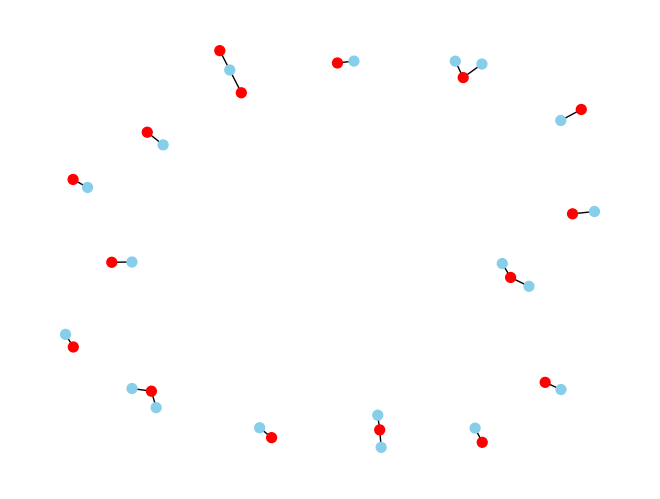

In [143]:

nx.draw(
    G,
    node_color=node_colors,
    with_labels=False,
    node_size=50
)

In [144]:
print(G.edges(data=True))

[('user_490', 'merch_31', {'trans_count': 1}), ('user_22', 'merch_0', {'trans_count': 1}), ('user_15', 'merch_83', {'trans_count': 1}), ('user_52', 'merch_45', {'trans_count': 1}), ('user_140', 'merch_83', {'trans_count': 1}), ('user_279', 'merch_45', {'trans_count': 1}), ('user_156', 'merch_84', {'trans_count': 1}), ('user_167', 'merch_27', {'trans_count': 1}), ('user_183', 'merch_7', {'trans_count': 1}), ('user_346', 'merch_53', {'trans_count': 1}), ('user_293', 'merch_29', {'trans_count': 1}), ('user_43', 'merch_93', {'trans_count': 1}), ('user_41', 'merch_5', {'trans_count': 1}), ('user_343', 'merch_54', {'trans_count': 1}), ('user_343', 'merch_89', {'trans_count': 1}), ('user_127', 'merch_24', {'trans_count': 1}), ('user_414', 'merch_87', {'trans_count': 1}), ('user_238', 'merch_53', {'trans_count': 1}), ('user_13', 'merch_39', {'trans_count': 1}), ('user_46', 'merch_84', {'trans_count': 1})]
